# Récupération des données
## (+ formalisation)

In [2]:
import numpy as np
import os
from scipy.io import loadmat

# Obtenir le dossier du script actuel
script_dir = os.path.dirname(os.path.abspath("pedsX.mat"))

# Construire le chemin vers le fichier .mat dans le même dossier
file_path = os.path.join(script_dir, "pedsX.mat")

# Vérifier que le fichier existe
if not os.path.isfile(file_path):
    raise FileNotFoundError(f"Fichier non trouvé : {file_path}")

# Charger le fichier .mat 
data = loadmat(file_path)

# Exemple : accéder à une variable
X = np.array(data["X"])  # convertir en ndarray pour sécurité

# Ici, on a récupéré la big matrice avec les images vectorisées (X c'est la vidéo)

# Estimation de b

## 1. Modélisation du problème

$$\min\limits_{b_i \in \mathbb{R}} \sum\limits_{j=1}^t | X(i, j) - b_i |$$

$\text{En posant : } | X(i, j) - b_i | = y_j \text{, nous obtenons l'expression suivante : } \min\limits_{b_i \in \mathbb{R}}\sum\limits_{j=1}^t y_j$

$\text{Pour que cela soit un problème d'optimisation, il faut le formuler comme suit :}$

$$
\min\limits_{b_i \in \mathbb{R}} \sum\limits_{j=1}^t y_j 
\quad \text{s.c.} \quad
\begin{cases}
y_j \geq X(i, j) - b_i & \forall j=1,\dots,t \\
y_j \geq b_i - X(i, j) & \forall j=1,\dots,t
\end{cases}
$$

$\text{Il s'agit donc d'un problème d'optimisation constitué de t équations et 2t contraintes}$

## 2. Ecriture sous forme standard

$\text{Les contraintes doivent se réecrire comme suit : }$

$$
\min\limits_{b_i \in \mathbb{R}}\sum\limits_{j=1}^t y_j
\quad \text{s.c.} \quad
\begin{cases}
y_j - X(i, j) + b_i^+ - b_i^- - s_{1j} =  0 \\
y_j - b_i^+ + b_i^- + X(i, j) - s_{2j} = 0 \\
y_j, s_{1j}, s_{2j}, b_i^+, b_i^- ≥ 0
\end{cases}

$$

## 3. Début du programme pour l'estimation de b

In [3]:
# Quelques librairies utiles
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import imageio.v2 as imageio

In [4]:
# On pose nos variables
# m et n sont les dimensions (en pixel) des images
m = int(data["m"])
n = int(data["n"])
p = m * n  # Taille du vecteur image (35263)
t = 100   # 100 images pour avoir une vidéo

/var/folders/1x/3d7rlrp10_l3ydb88jr0lsdm0000gn/T/ipykernel_55068/1300575703.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m = int(data["m"])
/var/folders/1x/3d7rlrp10_l3ydb88jr0lsdm0000gn/T/ipykernel_55068/1300575703.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(data["n"])


### Création des structures pour le problème :
$$\min{c^{T}x} \quad \text{tq} \quad Ax = b$$

In [6]:
# Coefficients (coûts) de la fonction objectif
c = np.zeros(3*t + 2)  # c contient tous les y_j 
c[2:2+t] = 1           # leur coeff vaut 1 et les s_j, b = 0

# Création de la matrice contraintes A (matrice de coefficients)
A = np.zeros((2*t, 3*t + 2))
for j in range(t):
    # Première contrainte : u_j - X(i,j) + (b_i^+ - b_i^-) - s_1j = 0
    A[j, 0] = 1
    A[j, 1] = -1
    A[j, 1 + j] = 1
    A[j, 1 + t + j] = -1

    # Deuxième contrainte : u_j + X(i,j) - (b_i^+ - b_i^-) - s_2j = 0
    A[t + j, 0] = -1
    A[t + j, 1] = 1
    A[t + j, 2 + j] = 1
    A[t + j, 2 + 2*t + j] = -1

bounds = [[0,None] for _ in range(3*t + 2)] # Pas de bornes pour les n+1 variables

# Création du vecteur b optimal
b_opt = np.zeros(p)
for i in range(p):
    b_eq = np.concatenate([X[i, :], -X[i, :]])
    model = linprog(c=c, A_eq=A, b_eq = b_eq, bounds=bounds)

    if model.success:
        #print(model.x[0], " et ", model.x[1])
        b_opt[i] = model.x[0] - model.x[1]
    else:
        print(f"Pixel {i}: {model.message}")

### Formatage + affichage

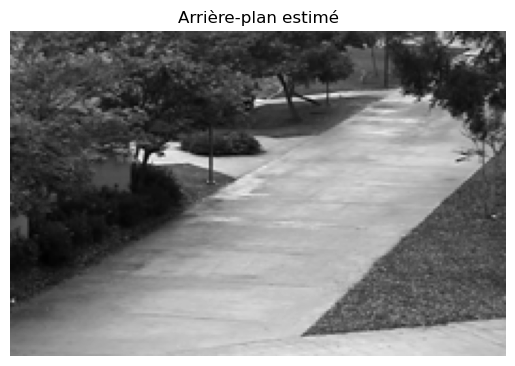

In [7]:
background = b_opt.reshape((n, m)).T    
background = 1 - background
#plt.imsave("background.png", background, cmap='gray'). Sauvegarder le fichier !
plt.imshow(background, cmap='gray')
plt.title("Arrière-plan estimé")
plt.axis('off')
plt.show()

## 4. Sommet du polyèdre
### Conditions à respecter pour qu'une solution soit un sommet du polyèdre.
#### - condition 1 : le point doit appartenir au polyèdre
#### - condition 2 : le point serre n contraintes
#### - condition 3 : les contraintes sont linéairement indépendantes 

Le problème est défini par 200 contraintes et 302 variables.

Nous avons donc intuitivement 200 hyperplans dans un espace à 302 dimensions.

La solution de ce problème ne peut pas être un sommet car il faudrait avoir autant de contraintes que de variables.

La condition 2 n'est donc pas satisfaite.

Néanmnoins, la décomposition de ce problème en p problèmes à une variable nous donne p solutions qui sont sommets de leur sous-problème respectif. 

Cela revient à minimiser localement chaque pixel.

# Estimation du vecteur a à partir du vecteur b obtenu

## 1. Modélisation du problème
$\text{Pour estimer le vecteur a, nous devons résoudre le problèmes d'optimisation suivants :}\\$
$$\min\limits_{a_{j} \in \mathbb{R}} ||X(:,j) - a_jb||_1 = \sum\limits_{i=1}^p |X(i,j) - a_jb_i|$$
$\text{Comme fait précedemment, nous réalisons un changement de variable afin de de transformer ce problème en un problème d'optimisation linéaire.}$

$\text{On pose :}$
$$|X(i,j) - a_jb_i| = y_i$$
$\text{Il faut donc inclure deux contraintes afin que le problème se formule de la façon suivante :}$

$$
\min\limits_{a_j \in \mathbb{R}} \sum\limits_{i=1}^p y_i 
\quad \text{s.c.} \quad
\begin{cases}
y_i \geq X(i, j) - a_jb_i & \forall i=1,\dots,p \\
y_i \geq a_jb_i - X(i, j) & \forall i=1,\dots,p
\end{cases}
$$

## 2.Ecriture sous forme standard

$\text{Pour écrire le problème sous forme standard, nous devons rajouter des variables d'écart afin de transformer les inégalités en égalités}$

$$
\min\limits_{a_j \in \mathbb{R}} \sum\limits_{i=1}^p y_i 
\quad \text{s.c.} \quad
\begin{cases}
y_i - X(i, j) + a_jb_i - s_{1i} = 0 \\
y_i - a_jb_i + X(i, j) - s_{2i} = 0 \\
y_i, s_{1i}, s_{2i}, a_j, b_i ≥ 0
\end{cases}
$$

In [10]:
from scipy.sparse import lil_matrix
# Coefficients (coûts) de la fonction objectif
c2 = np.zeros(3*p + 1) #p ~ 35 000
c2[1:1+p] = 1          

# Création de la matrice contraintes A (matrice de coefficients)
A2_sparse = lil_matrix((2*p, 3*p + 1))

for j in range(p):
    # Première contrainte
    A2_sparse[j, 0] = b_opt[j]
    A2_sparse[j, 1 + j] = 1
    A2_sparse[j, 1 + p + j] = -1

    # Deuxième contrainte
    A2_sparse[p + j, 0] = -b_opt[j]
    A2_sparse[p + j, 1 + j] = 1
    A2_sparse[p + j, 1 + 2*p + j] = -1

bounds2 = [[None, None]] + [[0, None] for _ in range(3*p)]
A2_sparse = A2_sparse.tocsr()
print(A2_sparse)

  (0, 0)	41.5
  (0, 1)	1.0
  (0, 35265)	-1.0
  (1, 0)	40.5
  (1, 2)	1.0
  (1, 35266)	-1.0
  (2, 0)	27.0
  (2, 3)	1.0
  (2, 35267)	-1.0
  (3, 0)	31.0
  (3, 4)	1.0
  (3, 35268)	-1.0
  (4, 0)	60.5
  (4, 5)	1.0
  (4, 35269)	-1.0
  (5, 0)	58.5
  (5, 6)	1.0
  (5, 35270)	-1.0
  (6, 0)	42.0
  (6, 7)	1.0
  (6, 35271)	-1.0
  (7, 0)	57.0
  (7, 8)	1.0
  (7, 35272)	-1.0
  (8, 0)	66.0
  :	:
  (70519, 105784)	-1.0
  (70520, 0)	36.5
  (70520, 35257)	1.0
  (70520, 105785)	-1.0
  (70521, 0)	32.0
  (70521, 35258)	1.0
  (70521, 105786)	-1.0
  (70522, 0)	31.0
  (70522, 35259)	1.0
  (70522, 105787)	-1.0
  (70523, 0)	24.0
  (70523, 35260)	1.0
  (70523, 105788)	-1.0
  (70524, 0)	30.0
  (70524, 35261)	1.0
  (70524, 105789)	-1.0
  (70525, 0)	38.0
  (70525, 35262)	1.0
  (70525, 105790)	-1.0
  (70526, 0)	35.5
  (70526, 35263)	1.0
  (70526, 105791)	-1.0
  (70527, 0)	38.5
  (70527, 35264)	1.0
  (70527, 105792)	-1.0


In [11]:
import numpy as np
from scipy.optimize import linprog

# === Paramètres globaux déjà définis avant dans ton notebook ===
# X, c2, A2_sparse, bounds2, t

def solve_all_problems():
    """
    Résout les t problèmes linéaires un par un en mode séquentiel
    et retourne le vecteur a_opt.
    """
    a_opt = np.zeros(t)

    for j in range(t):
        print(f"\n--- Début du calcul {j+1}/{t} ---")

        # On définit le b_eq correspondant à l'image j
        b_eq = np.concatenate([X[:, j], -X[:, j]])

        model2 = linprog(
            c=c2,
            A_eq=A2_sparse,
            b_eq=b_eq,
            bounds=bounds2,
            method='highs-ipm'  # plus rapide et adapté aux grands problèmes
        )

        if model2.success:
            a_opt[j] = model2.x[0]
        else:
            print(f"⚠ Pixel {j+1} : {model2.message}")
            a_opt[j] = np.nan  # pour ne pas masquer un éventuel échec

        print(f"--- Fin du calcul {j+1}/{t} ---")

    return a_opt

# === Exécution et sauvegarde ===
a_opt = solve_all_problems()

# Sauvegarde dans un fichier persistant (même si tu redémarres le kernel)
np.save("a_opt_results.npy", a_opt)

print("\nCalcul terminé et sauvegardé dans 'a_opt_results.npy'")



--- Début du calcul 1/100 ---
--- Fin du calcul 1/100 ---

--- Début du calcul 2/100 ---
--- Fin du calcul 2/100 ---

--- Début du calcul 3/100 ---
--- Fin du calcul 3/100 ---

--- Début du calcul 4/100 ---
--- Fin du calcul 4/100 ---

--- Début du calcul 5/100 ---
--- Fin du calcul 5/100 ---

--- Début du calcul 6/100 ---
--- Fin du calcul 6/100 ---

--- Début du calcul 7/100 ---
--- Fin du calcul 7/100 ---

--- Début du calcul 8/100 ---
--- Fin du calcul 8/100 ---

--- Début du calcul 9/100 ---
--- Fin du calcul 9/100 ---

--- Début du calcul 10/100 ---
--- Fin du calcul 10/100 ---

--- Début du calcul 11/100 ---
--- Fin du calcul 11/100 ---

--- Début du calcul 12/100 ---
--- Fin du calcul 12/100 ---

--- Début du calcul 13/100 ---
--- Fin du calcul 13/100 ---

--- Début du calcul 14/100 ---
--- Fin du calcul 14/100 ---

--- Début du calcul 15/100 ---
--- Fin du calcul 15/100 ---

--- Début du calcul 16/100 ---
--- Fin du calcul 16/100 ---

--- Début du calcul 17/100 ---
--- Fin du

In [12]:
a_opt = np.load("a_opt_results.npy")
print(a_opt)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
